In [1]:
import os
import cv2
import numpy as np
from time import time
import tensorflow as tf
import keras
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pylab as py
import random
import pylab as pl
from PIL import Image, ImageFilter


In [2]:
def visualize(train_dir):
    classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'space', 'nothing', 'del']
    plt.figure(figsize=(15, 15))
    for i in range (0,26):
        plt.subplot(8,8,i+1)
        plt.xticks([])
        plt.yticks([])
        path = train_dir + "/{0}/{0}27.jpg".format(classes[i])
        img = plt.imread(path)
        grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 80, 1, cv2.THRESH_BINARY)
        if(i==0):
            print(grayImage)
            print(img.shape)
        #img_gray = np.array(Image.open(path).convert('L'))
        #maxval = 1
        #im_bin = (img_gray > 95) * maxval
        #print(im_bin.shape)
        plt.imshow(blackAndWhiteImage)
        print(grayImage.shape)
        plt.xlabel(classes[i])

[[ 83  77  77 ...  75  79  79]
 [ 78  68  67 ...  63  67  76]
 [ 77  65  60 ... 188 193  61]
 ...
 [ 78  55 153 ... 130 148  58]
 [ 76  67 161 ... 148 149  66]
 [ 79  75  65 ...  60  66  68]]
(200, 200, 3)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)
(200, 200)


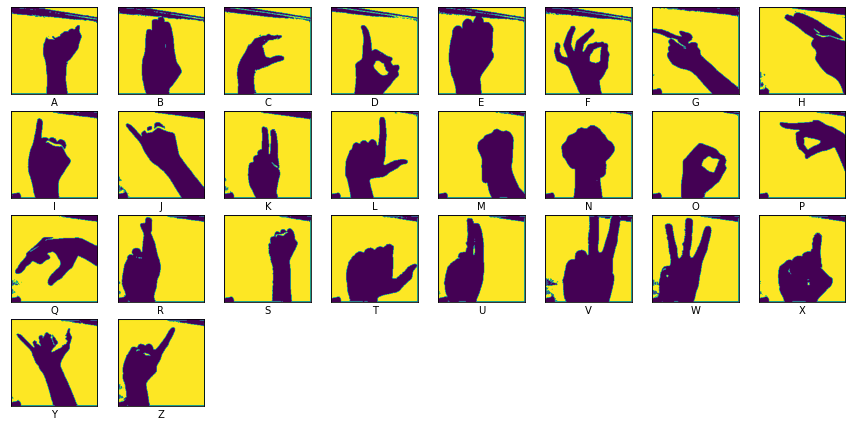

In [3]:
train_dir = './asl_alphabet_train/asl_alphabet_train'
visualize(train_dir)


In [4]:
def split_data(train_dir):
    images = []
    labels = []
    size = 50,50
    index = -1
    for folder in os.listdir(train_dir):
        index +=1
        for image in os.listdir(train_dir + "/" + folder):
            if image[0] != '.':
                temp_img = plt.imread(train_dir + '/' + folder + '/' + image)
                grayImage = cv2.cvtColor(temp_img, cv2.COLOR_BGR2GRAY)
                (thresh, temp_img) = cv2.threshold(grayImage, 90, 1, cv2.THRESH_BINARY)
                if type(temp_img) is np.ndarray:
                    temp_img = cv2.resize(temp_img, size)
                    images.append(np.reshape(temp_img,(2500)))
                    labels.append(index)
    images = np.array(images)
    #images = images.astype('float32')/255.0
    labels = utils.to_categorical(labels)
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1)
    np.save("x_train.npy",x_train)
    np.save("x_test.npy",x_test)
    np.save("y_train.npy",y_train)
    np.save("y_test.npy",y_test)
    return x_train, x_test, y_train, y_test

In [5]:
#from to_import import split_data
x_train, x_test, y_train, y_test = split_data(train_dir)


In [10]:
x_train2 = x_train[:500]
x_test2 = x_test[:100]
y_train2 = y_train[:500]
y_test2 = y_test[:100]

#im_bin = x_train[15]
#print(im_bin)
print(x_train2.shape)
print(x_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

#plt.imshow(im_bin)


(500, 2500)
(100, 2500)
(500, 27)
(100, 27)


In [11]:
print(y_train.shape)
Y_train = []
Y_test = []
vowels = [0,4,8,14,20]
for i in range(y_train2.shape[0]):
    Y_train.append(np.where(y_train2[i]==1)[0][0])
    #if Y_train[i] in vowels:
    #    Y_train[i] = [0,1]
   # else:
  #      Y_train[i] = [1,0]
for i in range(y_test2.shape[0]):
    Y_test.append(np.where(y_test2[i]==1)[0][0])
    
   # if Y_test[i] in vowels:
    #    Y_test[i] = [0,1]
   # else:
   #     Y_test[i] = [1,0]
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print(Y_train)


(70200, 27)
[19  7 11 17 22 17  4 10 20 20 12  8 10  5 18  4 23  0 26 12 18  1 22 20
 20 22 15 10 20 10 17 26 13  4 15  5 23 12 10  4 11  5  0  9 23  3  8  7
  3 22  7  0  0 15 13  1 25  5 21 15 26 10 25 11 24 26 22 13 12 23  3 18
 17  7 15 26 12 24  1 11  5  6  8 19  7 14  6 24 22  3  0 22 18 25 14 12
 24  5  4 25 24 12  6 14 15  4  9 22 14 26 12 13 15 17 22 10 23 23 12 23
 12 21  2  3 14  9  1 10 17  8 25 20  2 14  8 10  5  2 18 18 21 14 24 14
  2  1  4 11  6  8 25 15 25 20  1 17  6 19  4  7 10 24  5 24  4  6  5 18
 24 26 25 24 15  4 12  3  9 23  0 17 22  3 24 12 24 24 19  8  0 14  5 20
  8 26  8  1  1 12 11  2  7  5 20 11 19  5 19 13  3 22 21 10  0 10 21  2
 26 14 19 23  6 26 14  2 13 26 22  8 11  1  8 18 17 20  7 19 20 17 18 19
 10 15 12 17 17 10  8 25 18 24  9 17 17  0  0 18  7  2 14 14  9 14  2 14
 14 10 13 19 18 12 14 14 10  1  1  1 26  6  6  6  9 12  6 17  7  3  1  0
 14 22 15 13  8 21 22 19 25 17 12  8 22 13  4  5 24 15 12 14 19 17 15 17
  9 14 21 21  6  6 20  0 10 21 21 13 10

In [15]:
import gplearn

import pandas as pd
from gplearn.genetic import SymbolicRegressor,SymbolicClassifier
print(Y_train.shape)

(500,)


In [18]:
est_gp = SymbolicRegressor(population_size=100,
                           generations=500, tournament_size=20 ,stopping_criteria=1,
                           const_range=(0,26), init_depth = (2,6),
                           metric = fit,
                           function_set=('add', 'sub', 'mul', 'div'),
                           p_crossover=0.9, p_subtree_mutation=0.1,
                           p_hoist_mutation=0, p_point_mutation=0, verbose = 1, random_state=1)
est_gp.fit(x_train2,Y_train)
est_gp.score(x_test2, Y_test)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    30.48          0.02926        7            0.052              N/A     48.66s
   1     3.82          0.04866        1            0.054              N/A     36.43s
   2     1.46          0.05134        3            0.062              N/A     26.68s
   3     1.44          0.05348        3            0.062              N/A     24.87s
   4     3.58          0.05572        3            0.062              N/A     25.56s
   5     3.16          0.05336        3            0.062              N/A     25.52s
   6     2.98          0.05228        3            0.062              N/A     25.04s
   7     3.18           0.0529        3            0.062              N/A     25.41s
   8     3.36          0.05076        3            0.062              N/A  

-13.244797251996575

In [191]:
predicted = est_gp.predict(x_train)
correct = 0
for i in range(Y_train.shape[0]):
    if int(predicted[i]) == Y_train[i]:
        correct+=1

print("Accuracy: ", correct * 100 / Y_train.shape[0], "%" )
# threshold 127
# 2000 : 8.8%
# 2100 : 9.6%
# 2500 : 10.4%
# threshold 90
# 2000 : 11.6%
# 2100 : 

# threshold -> 80, gens -> 100
#2.8
# threshold -> 90, gens -> 100

#threshold -> 100, gens -> 100

Accuracy:  8.2 %


In [58]:
est_gp.set_params(generations=2100, warm_start=True)
est_gp.fit(x_train2,Y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
2000  1909.06          296.776     1953            29.14              N/A      1.22m
2001  1932.60          157.565     1923          29.1247              N/A      1.19m
2002  1904.42           313.28     1923          29.1247              N/A      1.15m
2003  1908.18          700.503     1973          29.1255              N/A      1.20m
2004  1908.70          97.0803     2031          29.1362              N/A      1.14m
2005  1906.40          3122.47     1941          29.1486              N/A      1.13m
2006  1918.96          415.535     1941          29.1538              N/A      1.12m
2007  1917.88          338.118     1943          29.1453              N/A      1.12m
2008  1925.06           356.79     1955          29.1453              N/A  

SymbolicRegressor(const_range=(-26, 26),
                  function_set=('add', 'sub', 'mul', 'div', 'min', 'max'),
                  generations=2100, init_depth=(2, 10), metric='mse',
                  p_hoist_mutation=0, p_point_mutation=0,
                  p_subtree_mutation=0.1, population_size=100, random_state=0,
                  stopping_criteria=0, verbose=1, warm_start=True)

In [17]:
def fitness(y, y_pred, w):
    fit = 0
    for i in range(len(y)):
        if y[i]==y_pred[i]:
            fit+=1
    return fit/len(y)

fit = gplearn.fitness.make_fitness(function = fitness, greater_is_better= True)

In [84]:
print(fitness([1,2,6],[4,5,6],5))

0.3333333333333333


In [19]:
import CGP
from CGP import cgpann

In [20]:
cgp_model = cgpann(num_features = x_train2.shape[1], num_outputs = 1, nodes=20, connections=3, generations=100,
                 offsprings=10, mutationRate=0.1, learning_rate=0.1,outMutationChance=0.2,
                 nodesPerOut=2, functions=3, gene_type=2, seed=42, verbose=True)

In [21]:
cgp_model.fit_data(x_train2,Y_train)

Generation number:  1  is having mse:  200.83
Generation number:  2  is having mse:  200.83
Generation number:  3  is having mse:  200.83
Generation number:  4  is having mse:  200.5815
Generation number:  5  is having mse:  197.577
Generation number:  6  is having mse:  196.687
Generation number:  7  is having mse:  194.712
Generation number:  8  is having mse:  194.712
Generation number:  9  is having mse:  194.712
Generation number:  10  is having mse:  194.712
Generation number:  11  is having mse:  194.712
Generation number:  12  is having mse:  194.537
Generation number:  13  is having mse:  194.537
Generation number:  14  is having mse:  194.537
Generation number:  15  is having mse:  194.537
Generation number:  16  is having mse:  194.537
Generation number:  17  is having mse:  194.537
Generation number:  18  is having mse:  194.537
Generation number:  19  is having mse:  194.537
Generation number:  20  is having mse:  194.537
Generation number:  21  is having mse:  194.537
Gen

[1737,
 0.6282446952642987,
 3824,
 -0.3445091936780324,
 3264,
 0.8206900040389516,
 0,
 2805,
 0.17248356064631698,
 1752,
 -0.8921494793784172,
 947,
 0.9594517817560086,
 2,
 1168,
 0.0437072726839684,
 1354,
 0.3216752553800077,
 2879,
 0.1265258011304225,
 0,
 2281,
 0.5339259787938155,
 879,
 -0.1404421178982257,
 918,
 0.3506948237448729,
 2,
 498,
 0.575063447796311,
 3240,
 0.7134826976033186,
 2667,
 0.4219020730086888,
 0,
 1509,
 0.49012189100336856,
 1673,
 -0.9712758972716027,
 17,
 -0.0206334376239279,
 1,
 2720,
 0.5874952338293664,
 1671,
 0.8377255313054396,
 3632,
 -0.6002178470582386,
 1,
 3677,
 -0.4002726498970066,
 2419,
 0.23399482033568245,
 2315,
 -0.37600020140256496,
 2,
 3149,
 -0.17446270219915544,
 1462,
 0.4152641402271193,
 2639,
 -0.6566814532281501,
 1,
 3883,
 0.9013577426062185,
 1860,
 -0.6675185006086015,
 2514,
 -0.9542456254200774,
 2,
 742,
 -0.9661469975180991,
 1815,
 0.35987804501131276,
 3314,
 -0.7461496279620288,
 2,
 3295,
 -0.054512472

In [23]:
def maxi (list):
    if list[0]>list[1]:
        return 0
    return 1
predicted = cgp_model.predict_data(x_train2)
correct = 0
for i in range(Y_train.shape[0]):
    print(predicted[i], end="")
    if predicted[i] == Y_train[i]:
        correct+=1
print()
print("Accuracy: ", correct * 100 / Y_train.shape[0], "%" )

[0.5][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][0.5][1.][0.5][1.][1.][1.][1.][0.5][1.][1.][1.][1.][1.][1.][1.][1.][0.5][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][0.5][1.][1.][1.][0.5][1.][1.][1.][1.][0.5][1.][1.][1.][1.][1.][0.5][1.][1.][1.][1.][1.][0.5][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][0.5][1.][1.][0.5][1.][1.][1.][1.][1.][0.5][0.5][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][0.5][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][0.5][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][0.5][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][0.5][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][0.5][1.][1.][1.][1.][0.5][1.][0.5][0.5][0.5][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][1.][

In [24]:
# The docopt str is added explicitly to ensure compatibility with
# sphinx-gallery.

import functools

import matplotlib.pyplot as plt
import numpy as np
from docopt import docopt

import cgp


In [25]:
def objective(individual, rng):
    """Objective function of the regression task.

    Parameters
    ----------
    individual : Individual
        Individual of the Cartesian Genetic Programming Framework.
    rng: numpy.random.RandomState

    Returns
    -------
    Individual
        Modified individual with updated fitness value.
    """
    if not individual.fitness_is_None():
        return individual

    n_function_evaluations = 1000

    f = individual.to_numpy()
    x = rng.uniform(-5, 5, size=n_function_evaluations)
    y = f(x)

    loss = np.mean((f_target(x) - y) ** 2)
    individual.fitness = -loss

    return individual

/opt/conda/envs/common/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
def f_traget(x):
    i, = np.where(Y_train == value)
    return i

/opt/conda/envs/common/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
population_params = {
    "n_parents": 1,
    "seed": 8188211,
}

genome_params = {
    "n_inputs": x_train2.shape[0],
    "n_outputs": 1,
    "n_columns": 20,
    "n_rows": 500,
    "levels_back": None,
    "primitives": (cgp.IfElse, cgp.Mul, cgp.Add, cgp.Sub, cgp.ConstantFloat,),
}

ea_params = {"n_offsprings": 4, "mutation_rate": 0.03, "n_processes": 2}

evolve_params = {"max_generations": 30, "termination_fitness": 0.0}

# create population that will be evolved
pop = cgp.Population(**population_params, genome_params=genome_params)

# create instance of evolutionary algorithm
ea = cgp.ea.MuPlusLambda(**ea_params)

# define callback for recording of fitness over generations
history = {}
history["fitness_champion"] = []
history["expr_champion"] = []


def recording_callback(pop):
    history["fitness_champion"].append(pop.champion.fitness)
    try:
        sympy_expression = pop.champion.to_sympy()
    except TypeError:
        sympy_expression = pop.champion.to_sympy(simplify=False)

    history["expr_champion"].append(sympy_expression)


# the objective passed to evolve should only accept one argument,
# the individual
rng = np.random.RandomState(seed=population_params["seed"])
obj = functools.partial(objective, rng=rng)

# Perform the evolution
cgp.evolve(pop, obj, ea, **evolve_params, print_progress=True, callback=recording_callback)

/opt/conda/envs/common/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: input has length 1, expected 500